## Bollinger Band

In [1]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

url ="https://www.alphavantage.co/query"

params = {
    "function":"TIME_SERIES_DAILY_ADJUSTED",
    "symbol": "GOOG",
    "apikey": "TU10HCWDTV5CNVBN"
}

response = requests.get(url, params=params)
data = response.json()

def convert_response(d):
    for dt, prec in d['Time Series (Daily)'].items():
        r = {'datetime': dt}
        r.update(prec)
        yield r

df = pd.DataFrame(convert_response(data))
# rename the columns    
df = df.rename(columns={ '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. adjusted close': 'AdjClose', '6. volume': 'Volume'})
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
# extract the columns you want
df = df[[ 'Close']]

In [2]:
df=df.astype(float)

In [40]:
df['MA'] = df['Close'].rolling(window=12).mean()
df['STD'] = df['Close'].rolling(window=12).std()
df['Upper Band'] = df['MA'] + (df['STD'] * 2)
df['Lower Band'] = df['MA'] - (df['STD'] * 2)

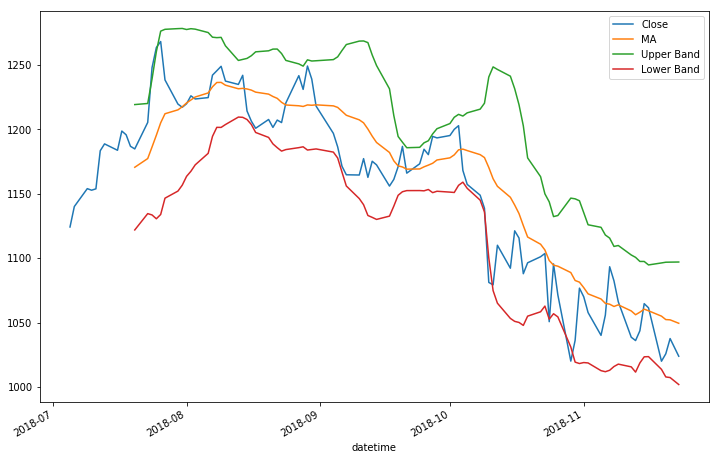

In [41]:
df[['Close','MA','Upper Band','Lower Band']].plot(figsize=(12,8))
    

In [39]:
df['Upper Band'].head()

datetime
2018-07-05   NaN
2018-07-06   NaN
2018-07-09   NaN
2018-07-10   NaN
2018-07-11   NaN
Name: Upper Band, dtype: float64